# Workbook 02: Exploring word embeddings

В цій лабораторній ми детальніше розберемося з векторним представленням слів (word embeddings), а саме:

- Завантажимо вектори GloVe
- Перевіримо цікаві властивості цих векторів

У вас буде кілька завдань. Відповіді на завдання відправляють функції `lab.checkpoint()` та `lab.answer()`.

Для початку, заповніть параметр `email` нижче:

In [1]:
!pip install --quiet --ignore-installed requests==2.32.4 https://static.lp-nlp.com/pypi/lpnlp-2025.9.29.dev1-py3-none-any.whl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [2]:
import lpnlp
lab = lpnlp.start(
    email="denys.koval.shi.2022@lpnu.ua",  # <---------------------- Заповніть це поле
    lab="exploring_word_embeddings"
    )


Удачі!


# GloVe

In [3]:
!pip install gensim

Повний GloVe містить 4,000,000 векторів і займає багато пам'яті. Щоб уникнути проблем з пам'ятю, залишимо лише 50,000 векторів найчастотніших слів. Це трохи знизить якість моделей, але це зараз не головне.

In [4]:
import gensim.downloader
from gensim.models import KeyedVectors
import tqdm


# Ця функція завантажить повний набір GloVe векторів та залишить `max_n` з них
def load_glove_subset(max_n: int) -> KeyedVectors:
    """Return top `max_n` word vectors. """
    all_glove = gensim.downloader.load("glove-wiki-gigaword-200")
    subset = KeyedVectors(all_glove.vector_size)
    for word in tqdm.tqdm(all_glove.key_to_index, total=max_n):
        if len(subset.vectors) >= max_n:
            break
        subset.add_vector(word, all_glove[word])
    return subset

# Цей виклик може зайняти хвилин 5-6, тож ми завантажимо вже готові 50k векторів
# glove = load_glove_subset(50_000)
glove = KeyedVectors.load("http://static.lp-nlp.com/files/glove-50k.bin")

In [5]:
lab.checkpoint("glove subset size", len(glove.key_to_index))

Відповідь правильна ✅



50000

Об'єкт `glove` може працювати як звичайний словник (`dict`), ключами якого є токени, а значеннями - вектори слів. Вектори, які ми завантажили, були натреновані на lower-cased текстах, тож і шукати вектори треба для слів у нижньому регістрі.

Подивимося, як виглядає вектор слова "ukraine":

In [6]:
glove["ukraine"]

array([-2.9835e-01,  2.0119e-01,  1.0576e+00, -3.0105e-01, -4.6139e-01,
       -2.3603e-02,  7.0583e-01,  2.5945e-01,  2.8852e-01,  5.5536e-01,
       -4.9120e-01,  2.6961e-01, -2.4428e-02, -2.1458e-02,  1.1455e+00,
        6.8221e-01, -2.9128e-01, -2.2623e-01, -2.0675e-01,  1.3855e-01,
       -1.8925e-01,  2.3665e+00, -9.9162e-01, -2.4470e-01,  2.4622e-01,
       -1.1827e-01,  3.8615e-01, -2.6921e-01, -3.8376e-02, -5.2927e-01,
       -8.2827e-02, -2.8802e-01, -4.3625e-01, -2.1721e-01, -9.3741e-01,
        4.2792e-01, -8.3241e-01, -3.7487e-02, -5.8459e-01, -5.4755e-01,
       -5.6027e-01,  1.8893e-01,  1.4222e-01,  2.0484e-01,  2.0384e-01,
       -3.7074e-01,  4.3972e-01, -3.4872e-01,  1.2722e-01, -4.1341e-01,
        7.1163e-01, -6.5506e-01, -4.4388e-01,  1.9223e-01, -3.9496e-01,
       -6.6644e-01, -5.9630e-01, -7.9109e-02,  5.3330e-01,  9.3981e-01,
       -7.1796e-01,  5.0569e-01,  6.4526e-01, -2.6927e-01,  3.8530e-01,
        5.5825e-01,  6.5299e-02,  3.5928e-01,  2.3044e-01, -2.33

### Завдання

Знайдіть кількість та середнє значення (mean) елементів вектора слова "ukraine"

In [7]:
##########################
# ВАШ КОД ТУТ:
size_v_ukraine = len(glove["ukraine"])
mean_v_ukraine = sum(glove["ukraine"])/len(glove["ukraine"])
size_v_ukraine, mean_v_ukraine
##########################
lab.checkpoint("size of 'ukraine'", size_v_ukraine)
lab.checkpoint("mean of 'ukraine'", mean_v_ukraine)

Відповідь правильна ✅

Відповідь правильна ✅



0.03348933080909774

# Подібність слів

### Косинус подібності (cosine similarity)

Дуже часто метрикою близькості двох векторів слугує косинус подібності (cosine similarity). Косинус кута між двома векторами буде дорівнювати 1, коли напрями векторів точно збігаються. Для ортогональних векторів косинус дорівнює 0, а для протилежних -1.

Косинус кута можна порахувати через векторний добуток:

$$ \text{similarity}(p, q) = \cos {\theta} = \frac {p \cdot q} {|p| |q|} $$

$|x|$ означає довжину вектора $x$:

$$|x| = \sqrt {x ^ 2} $$

### Завдання

Напишіть функцію обчислення cosine similarity

In [50]:
import numpy as np
from math import isclose

def normalize(v):
    return v / np.sqrt(v @ v)

def cosine_similarity(v1: np.ndarray, v2: np.ndarray) -> float:
    ###########################
    # Ваш код
    ###########################
    similarity = np.float64(normalize(v1) @ normalize(v2))
    return similarity

# Знайдіть косинус подібності слів "apple" та "google"
cos_0 = cosine_similarity(glove["apple"], glove["google"])
# assert isinstance(cos_0, float)
lab.checkpoint("cosine similarity between 'apple' and 'google'", float(cos_0))

Відповідь правильна ✅
Так, вірно! 💪


0.5554561018943787

### Завдання

Знайти подібність словa "awesome" до слів "amazing", great" та "bad"

In [53]:
glove.cosine_similarities(glove["awesome"], [glove["amazing"]])

array([0.69670796], dtype=float32)

In [55]:
cos_1 = cosine_similarity(glove['awesome'], glove['amazing'])
lab.checkpoint("cosine_similarity between 'awesome' and 'amazing'", cos_1)

Відповідь неправильна 🛑



0.6967080235481262

In [56]:
cos_2 = cosine_similarity(glove['awesome'], glove['great'])
lab.checkpoint("cosine_similarity between 'awesome' and 'great'", cos_2)

Відповідь неправильна 🛑



0.45695698261260986

In [57]:
cos_3 = cosine_similarity(glove['awesome'], glove['bad'])
lab.checkpoint("cosine_similarity between 'awesome' and 'bad'", cos_3)

Відповідь неправильна 🛑



0.3114391565322876

## Пошук подібних слів

Завдяки векторному представленню, ми можемо уявляти собі слова точками в багатовимірному просторі. Близькі за семантикою (змістом) або морфологією (як одиниці мови) слова будуть відповідати близькими між собою точками.

Атож, найближчі сусіди слова будуть або синонимами, або антонімами, або виконувати ту саму роль в реченні.

Як знайти сусідів вектора певного слова? Наївне рішення — перебрати всі вектори і обчислити відстань до кожного з них. Для великих словників це може зайняти багато часу. Для великих словників або коли необхідно робити багато запитів, використовують методи приблизного пошуку векторів, такі як LSH або [faiss](https://github.com/facebookresearch/faiss). Ці методи попередньо будують індекси для векторів, які дозволяють здійснювати пошук подібних векторів дуже швидко (і з маленькою, але ненульовою ймовірністю пропускати деяких сусідів)

Оскільки наш словник є дуже невеликим (50 тисяч токенів), то можемо дозволити собі наївне рішення.

In [19]:
from typing import List, Tuple

def find_similar(word: str , top_n: int = 10) -> List[Tuple[float, str]]:
    """Повертає `top_n` сусідів слова `word` разом з подібністю.

    Returns:
        list of (similarity, word) tuples.
    """
    # Рахуємо подібність вектора слова `word` з кожним іншим словом
    # Словник всіх слів міститься в `glove.vocab`

    ################### ВАШ КОД ТУТ
    result = sorted(((cosine_similarity(glove[w], glove[word]), w) for w in glove.index_to_key if w != word), key=lambda t: t[0], reverse=True)[:top_n]
    ###############################

    return result


find_similar("awesome")

[(0.7240041494369507, 'unbelievable'),
 (0.7075759172439575, 'incredible'),
 (0.6967080235481262, 'amazing'),
 (0.6145412921905518, 'fantastic'),
 (0.6071451306343079, 'terrific'),
 (0.5814316868782043, 'marvelous'),
 (0.5781935453414917, 'awful'),
 (0.5776978135108948, 'wonderful'),
 (0.5741086602210999, 'phenomenal'),
 (0.5519749522209167, 'tremendous')]

In [20]:
find_similar("awful")

[(0.8684825897216797, 'horrible'),
 (0.8322069644927979, 'terrible'),
 (0.7476429343223572, 'dreadful'),
 (0.6913045644760132, 'unbelievable'),
 (0.6799401044845581, 'horrendous'),
 (0.6458765864372253, 'appalling'),
 (0.6423128843307495, 'really'),
 (0.6418579816818237, 'bad'),
 (0.6389516592025757, 'horrifying'),
 (0.6362232565879822, 'thing')]

In [21]:
find_similar("green")

[(0.6953294277191162, 'red'),
 (0.6699603796005249, 'yellow'),
 (0.6597475409507751, 'blue'),
 (0.6384711861610413, 'brown'),
 (0.6299036145210266, 'orange'),
 (0.6277689933776855, 'purple'),
 (0.6158420443534851, 'bright'),
 (0.6116896867752075, 'black'),
 (0.585483968257904, 'pink'),
 (0.5821937918663025, 'white')]

In [22]:
lab.checkpoint("most similar to 'green'", find_similar("green")[0][1])

Відповідь правильна ✅
Цей крок не має автоматичної перевірки, рухаємося далі


'red'

Бібліотека `gensim`, за допомогою якої ми завантажували вектори, також вміє робити пошук подібних векторів, але значно швидше. Порівняємо з нашою імплементацією:

In [27]:
glove.most_similar("twitter")

[('facebook', 0.8435289263725281),
 ('myspace', 0.7275673747062683),
 ('youtube', 0.7193448543548584),
 ('blogging', 0.6892951130867004),
 ('blogs', 0.6891331672668457),
 ('tweets', 0.6888565421104431),
 ('blog', 0.6630491614341736),
 ('website', 0.6033923625946045),
 ('tweet', 0.5992511510848999),
 ('email', 0.5801640152931213)]

In [25]:
find_similar("facebook")

[(0.8435288071632385, 'twitter'),
 (0.8185950517654419, 'myspace'),
 (0.7537195086479187, 'youtube'),
 (0.6714472770690918, 'google'),
 (0.6526655554771423, 'blogs'),
 (0.646706759929657, 'blog'),
 (0.6389558911323547, 'web'),
 (0.6388846039772034, 'website'),
 (0.6286188364028931, 'zuckerberg'),
 (0.6250429749488831, 'websites')]

### Завдання

Знайдіть найближчого сусіда до слова `cat` (одне слово)

In [33]:
cat_top_synonym = find_similar("cat", top_n=1)[0][1]
assert isinstance(cat_top_synonym, str)
lab.checkpoint("Most similar word to `cat`", cat_top_synonym)

Відповідь правильна ✅
Цей крок не має автоматичної перевірки, рухаємося далі


'dog'

### Завдання

Спробуйте функцію `find_similar` на різних словах. Які пари здалися вам найбільш цікавими, дивними або нелогічними?

In [37]:
interesting_pairs = [{word: find_similar(word, top_n=3)} for word in ["programmer", "danger", "happiness", "life"]]
interesting_pairs

[{'programmer': [(0.6503490805625916, 'programmers'),
   (0.5555604696273804, 'software'),
   (0.5384970307350159, 'animator')]},
 {'danger': [(0.7697410583496094, 'threat'),
   (0.7006272673606873, 'dangers'),
   (0.6926029920578003, 'risk')]},
 {'happiness': [(0.637515127658844, 'joy'),
   (0.5966818928718567, 'enjoyment'),
   (0.5922440886497498, 'despair')]},
 {'life': [(0.7301627993583679, 'lives'),
   (0.6645193696022034, 'time'),
   (0.6602749228477478, 'even')]}]

In [38]:
interesting_pair = ("programmer", "animator")   # пара слів, наприклад ("awesome", "aweful")
lab.checkpoint("Interesting/strange pairs", interesting_pair)

Відповідь правильна ✅
Цей крок не має автоматичної перевірки, рухаємося далі


('programmer', 'animator')

# Візуалізація

In [39]:
from sklearn import manifold
import matplotlib.pyplot as plt


def plot_word_embeddings(model, search_list):
    words = []
    for term in search_list:
        words += [w[0] for w in model.most_similar([term], topn=5)]
    words += search_list
    words = list(set(words))

    vectors = model[words]

    tsne = manifold.TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=7)
    T = tsne.fit_transform(vectors)

    plt.figure(figsize=(16, 10))
    plt.scatter(T[:, 0], T[:, 1])
    for label, x, y in zip(words, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points')

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


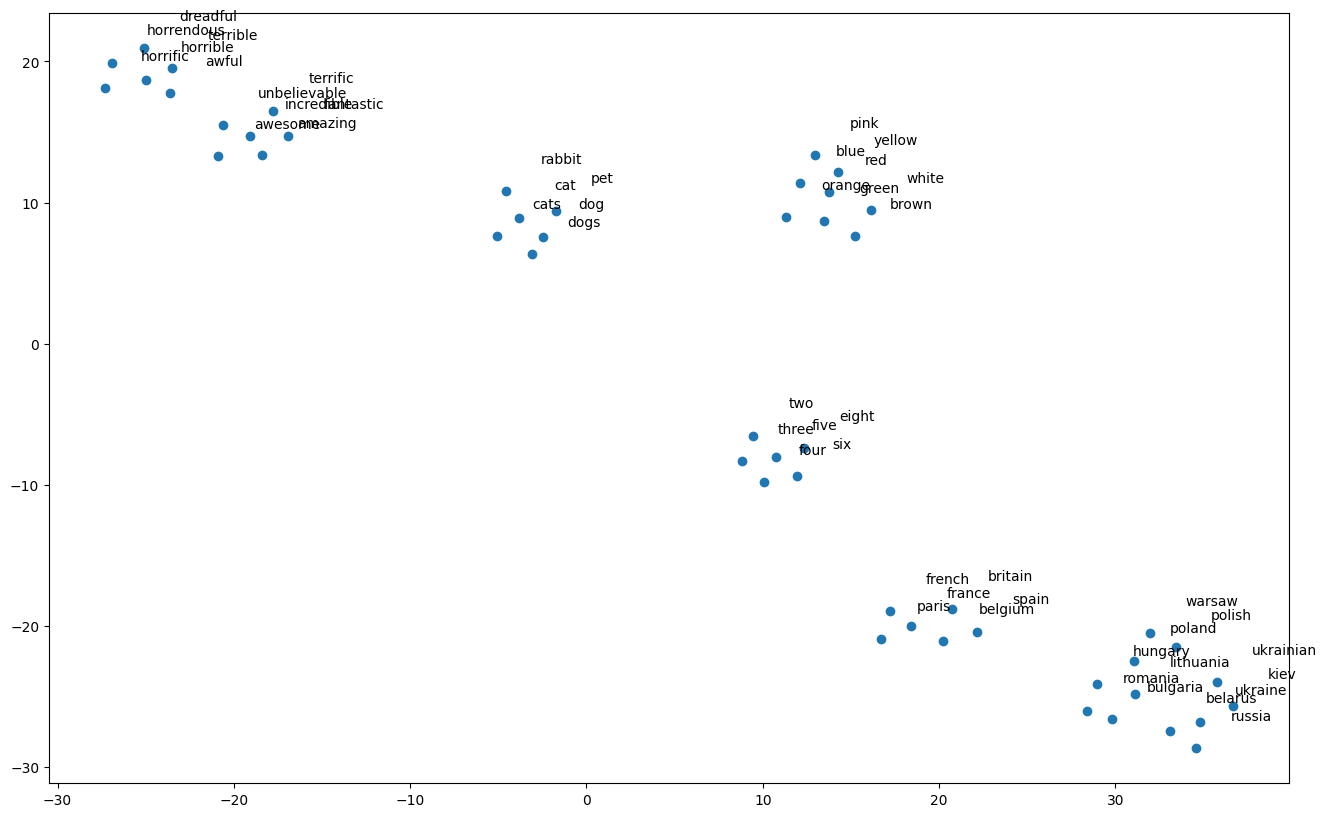

In [40]:
plot_word_embeddings(glove, ["awesome", "terrible", "ukraine", "poland", "france", "red", "green", "cat", "two"])

# Векторна аріфметика

Ми можемо додавати та віднімати вектори слів. Результат таких операцій (який теж буде вектором) можна перетворити назад в слово. Для цього знайдемо кілька найближчих до результата векторів і подивимося, які слова їм відповідають.

Векторну аріфметику використовують для пошуку слів за аналогіями. Класичний приклад з першої статті про Word2Vec виглядає так:

```
V("king") - V("man") + V("woman") ~= V("queen")
```

In [41]:
glove.similar_by_vector(glove["king"] - glove["man"] + glove["woman"])

[('king', 0.8209066987037659),
 ('queen', 0.7119165658950806),
 ('princess', 0.6121214628219604),
 ('monarch', 0.6024806499481201),
 ('prince', 0.596004068851471),
 ('throne', 0.5915313363075256),
 ('daughter', 0.5588055849075317),
 ('elizabeth', 0.554740309715271),
 ('kingdom', 0.5494517087936401),
 ('mother', 0.5419816970825195)]

### Завдання

Знайдіть найближчий вектор виразу
`paris` - `france` + `ukraine`

In [58]:
answer = glove[glove.similar_by_vector(glove["paris"] - glove["france"] + glove["ukraine"])[0][0]]
lab.answer(answer)   # мені теж не подобається те, як написана відповідь :)

Відповідь неправильна 🛑
Ні, не так... 🤔


'array([ 0.33837  , -0.33449  ,  0.32376  , -0.47067  , -0.067872 ,\n       -0.19849  ,  0.35414  , -0.23648  ,  0.66301  ,  0.84624  ,\n       -0.1528   ,  0.03349  ,  0.093928 , -0.14252  ,  0.77747  ,\n        0.20444  , -0.055331 , -0.24288  ,  0.21043  , -0.42946  ,\n       -0.088005 ,  1.6938   , -0.40403  , -0.044203 ,  0.33566  ,\n        0.12688  ,  0.58538  , -0.70038  , -0.089531 ,  0.11983  ,\n       -0.051915 , -0.23151  , -0.70637  , -0.31108  , -0.57605  ,\n        0.025228 , -0.5821   ,  0.033074 , -0.19141  , -0.47864  ,\n       -0.30276  ,  0.2124   ,  0.079464 ,  0.025553 ,  0.66366  ,\n        0.013374 ,  0.072936 ,  0.28364  ,  0.24684  , -0.31118  ,\n        0.94499  , -0.15414  ,  0.23199  , -0.01301  , -0.18744  ,\n       -0.73624  ,  0.12324  , -0.051619 ,  0.18545  ,  0.58658  ,\n       -0.52075  ,  0.012065 ,  0.85515  , -0.35414  , -0.23764  ,\n       -0.27422  , -0.013574 ,  0.25017  ,  0.60414  , -0.17911  ,\n       -1.3373   , -0.39639  , -0.3457   , -0.2

# Готово!

На наступному занятті ми:
- Використаємо ембедінги слів для класифікації текстів
- Дізнаємося, як влаштований word2vec
- Напишемо свою імплементацію word2vec
- Подивимося, як обійти проблему несловникових токенів
